In [2]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
house_prices <- source('main.R', local = TRUE)$value

combined_dataset <-
    house_prices$helpers$load_data() %>%
    (house_prices$outliers$remove_outliers) %>%
    (house_prices$missing$fix_all) %>%
    select(-Id)

test_that("should be no NA values except SalePrice column", {
    expect_equal(sum(is.na(combined_dataset %>% select(-SalePrice))), 0)
})

combinedDatasetNumeric <- combined_dataset %>% select_if(is.numeric) %>% select(-SalePrice)

In [8]:
trans <- tribble(
    ~tran_name, ~tran_fn,
    'log',      function(x) log(x+1),
    'sqrt',     function(x) sqrt(x),
    'inv3',  function(x) x**(1/3),
    'inv4',  function(x) x**(1/4)
)

transformation_config <- 
    house_prices$trans$numeric$Tran$get_transformation_config(
        dataset=combinedDatasetNumeric,
        trans=trans
    ) %>% 
    filter(progress_score > 30)

transformation_config

var,tran_name,progress_score,tran_fn
GrLivArea,log,91.15794,"function (x) , log(x + 1)"
X1stFlrSF,log,90.77166,"function (x) , log(x + 1)"
BsmtUnfSF,sqrt,79.97603,"function (x) , sqrt(x)"
LotArea,inv4,78.86403,"function (x) , x^(1/4)"
TotRmsAbvGrd,log,30.68502,"function (x) , log(x + 1)"


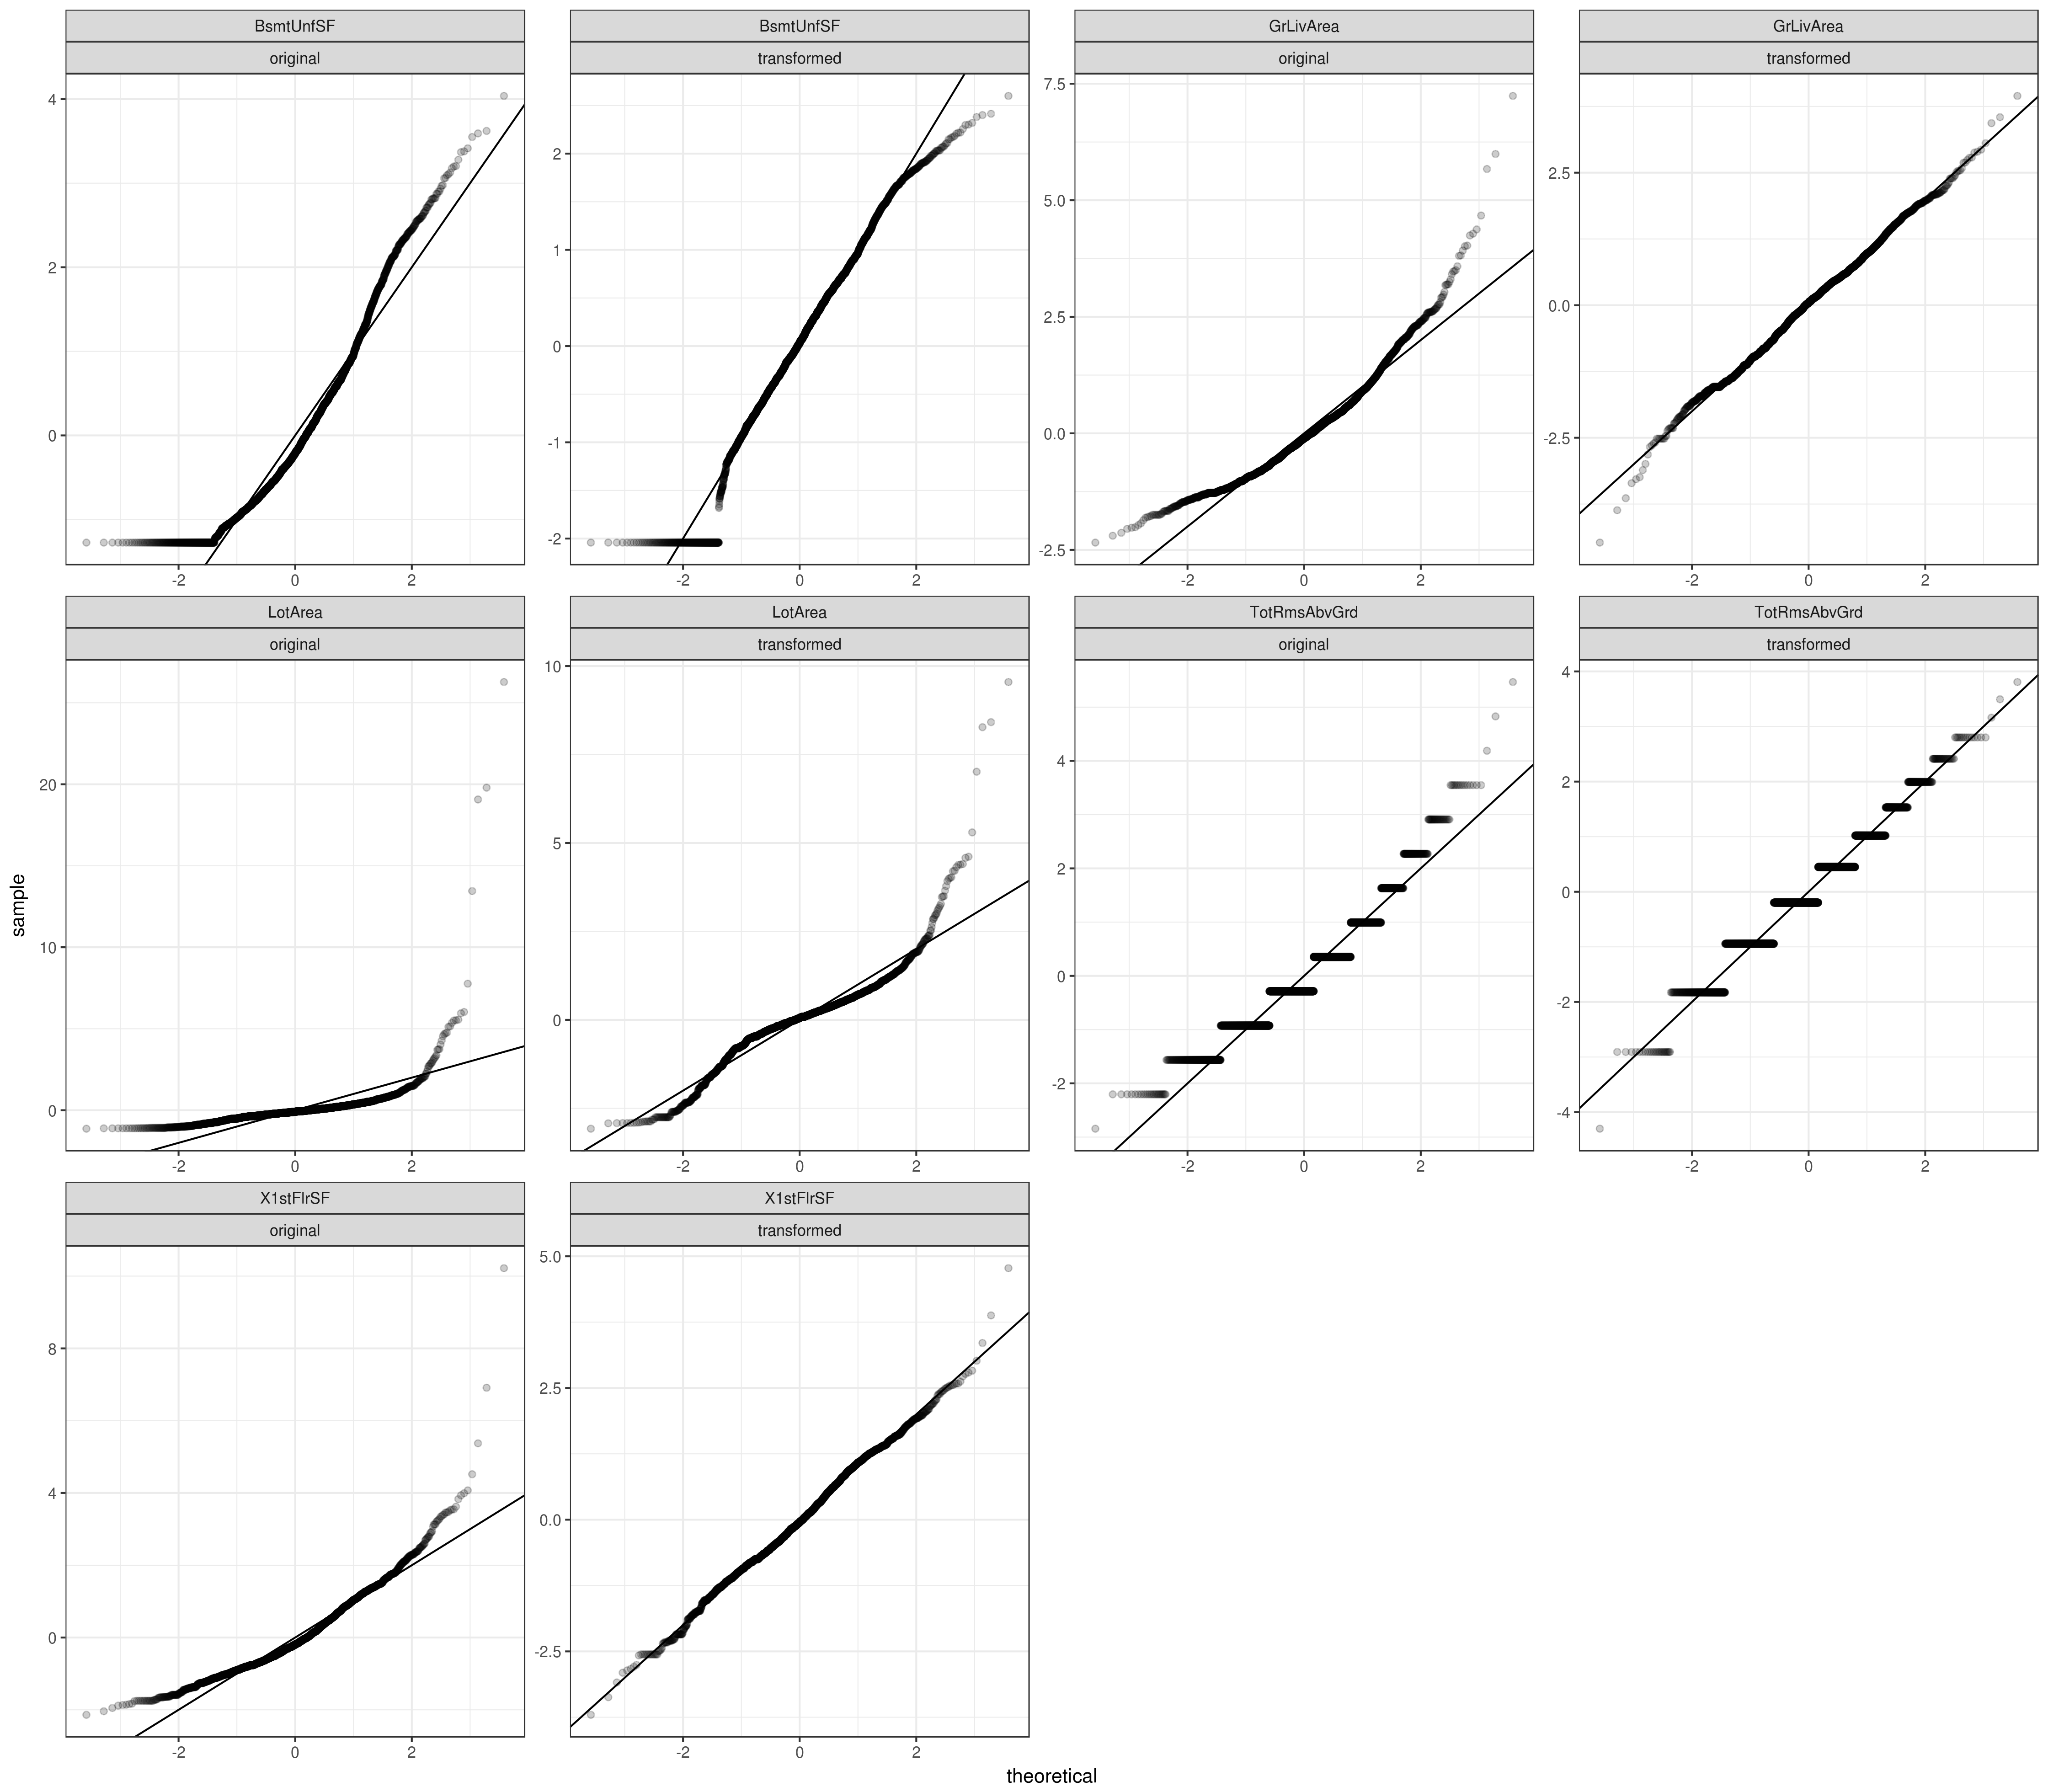

In [9]:
options(repr.plot.width = 16, repr.plot.height = 14, repr.plot.res=280)

df <- house_prices$trans$numeric$Tran$for_qq_plot(combined_dataset, transformation_config)

df %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(var~tran, ncol=4, scales="free") +
geom_abline(slope=1) +
theme_bw()

In [14]:
source('main.R')

transformation_config <- house_prices$trans$numeric$Tran$get_transformation_config(
    dataset=combinedDatasetNumeric,
    trans=trans
)

transformed_numeric <-
    house_prices$trans$numeric$Tran$apply_transform(combinedDatasetNumeric, transformation_config)


test_that("should be equal", {
    expect_equal(
        transformed_numeric %>% select(-one_of(transformation_config$var)), 
        combinedDatasetNumeric %>% select(-one_of(transformation_config$var))
    )
})

test_that("GrLivArea", {
    expect_equal(
        transformed_numeric$GrLivArea, 
        log(combined_dataset$GrLivArea + 1)
    )
})

test_that("BsmtUnfSF", {
    expect_equal(
        transformed_numeric$BsmtUnfSF, 
        sqrt(combined_dataset$BsmtUnfSF)
    )
})

test_that("LotArea", {
    expect_equal(
        transformed_numeric$LotArea, 
        (combined_dataset$LotArea)**(1/4)
    )
})